In [19]:
wood = list(''.join('SHW HSS WSS SHS SHH \
                     HHH WHH SWS WHS WWW \
                     SSW WSH HWS HHH SSW \
                     SSS WSH SSH HHW SSH'.split()))

nook_miles_island = list(''.join('CCIIICSC IIIIICGC CISCIIIC ICIISIII'.split()))

island = list(''.join('ISSIGSCS IISSICSI CISCISCI SCSCCSII SSICSIIC'.split()))

In [20]:
wood[0]

'S'

In [3]:
import math
import numpy

In [25]:
math.gamma(7)

720.0

In [27]:
wood_indexed = {}
idx = 0

for char in wood:
    if char not in wood_indexed:
        wood_indexed[char] = idx
        idx += 1

wood_indexed = [wood_indexed[char] for char in wood]

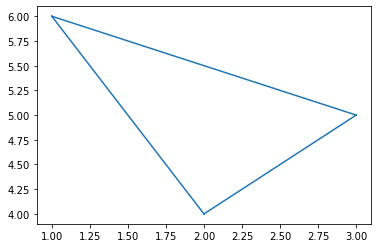

In [51]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

plt.triplot([1, 2, 3], [6, 4, 5])

In [136]:
prior = {'S': 1, 'H': 1, 'W': 1}

for idx, char in enumerate(wood):
    current = Counter(wood[:idx])
    den = math.gamma(sum(current.values()) + 1 + sum(prior.values()))
    beta_S = math.gamma(current['S'] + prior['S'])
    beta_H = math.gamma(current['H'] + prior['H'])
    beta_W = math.gamma(current['W'] + prior['W'])
    
    beta = beta_S * beta_H * beta_W / den

In [130]:
import numpy as np
import math
from operator import mul
from functools import reduce

class DirichletDistribution:
    
    def __init__(self, alphas, prior='uniform'):
        
        alphas = np.asarray(alphas)
        
        self.dim = alphas.shape[0]
        
        if prior == 'uniform':
            self.prior = np.ones(self.dim)
        else:
            self.prior = np.asarray(prior)
            
        assert alphas.shape == self.prior.shape

        self.alphas = alphas
        
        den = math.gamma(self.alphas.sum() + self.prior.sum())
        
        self.beta = reduce(mul,
                           [math.gamma(self.alphas[idx] + self.prior[idx])
                            for idx in range(self.dim)]
                           ) / den
    
    def pdf(self, x):
        x = np.asarray(x)
        assert x.shape == (3,)
        #assert x.sum() == 1, f'x does not sum to 1. {x}'
        
        return reduce(mul,
                      [coord ** (self.alphas[idx] + self.prior[idx] - 1)
                       for idx, coord in enumerate(x)]
                      ) / self.beta

In [131]:
dist = DirichletDistribution([1,2,1])

In [132]:
dist.pdf([1/3, 1/4, 1 - 1/3 - 1/4])

3.125

In [216]:
import matplotlib.tri as tri


# taken from https://github.com/yusueliu/medium/blob/master/scripts/plot_dirichlet.py
class PlotDirichlet:
    def __init__(self, corners):
        self._corners = corners
        self._triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
        # Midpoints of triangle sides opposite of each corner
        self._midpoints = [(corners[(i+1) % 3] + corners[(i+2) % 3]) / 2.0 for i in range(3)]
        
    def xy2bc(self, xy, tol=1.e-3):
        # change xy coords to barycentric coordinates
        s = [(self._corners[i] - self._midpoints[i]) @ (xy - self._midpoints[i]) / 0.75 for i in range(3)]
        return np.clip(s, tol, 1.0-tol)
    
    def bc2xy(self, coords):
        weights = coords
        x = sum([corner[0] * weight for (weight, corner) in zip(weights, self._corners)])
        y = sum([corner[1] * weight for (weight, corner) in zip(weights, self._corners)])
        return np.asarray((x, y))
        
    def draw_pdf_contours(self, ax, dist, label=None, nlevels=200, subdiv=8, **kwargs):

        # Subdivide the triangle into a triangular mesh
        refiner = tri.UniformTriRefiner(self._triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)
        
        # convert to barycentric coordinates and compute probabilities of the given distribution 
        pvals = [dist.pdf(self.xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    
        ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
        #plt.axis('equal')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 0.75**0.5)
        #ax.set_title(str(label))
        #ax.axis('off')
        return ax

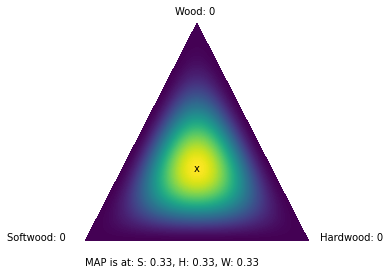

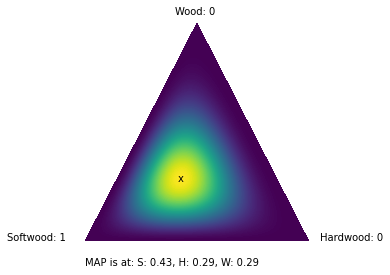

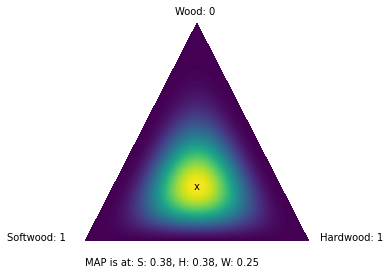

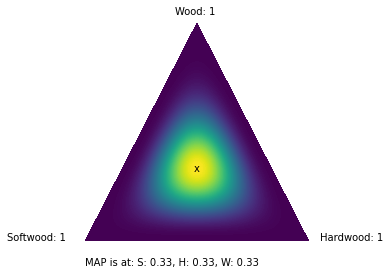

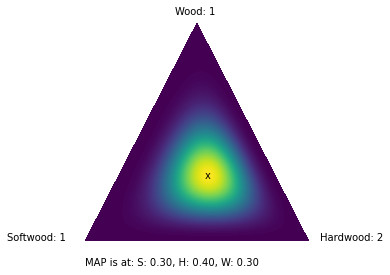

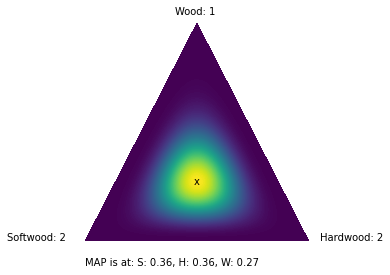

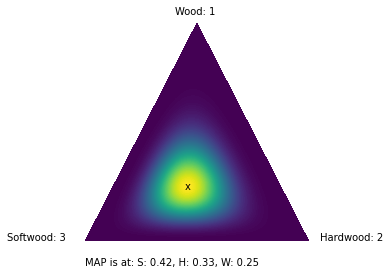

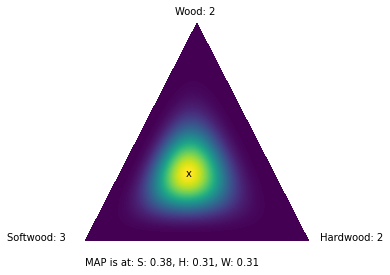

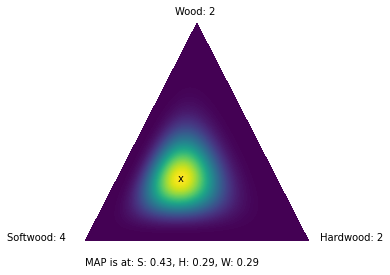

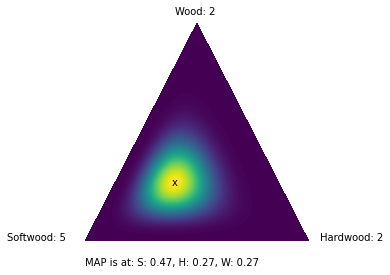

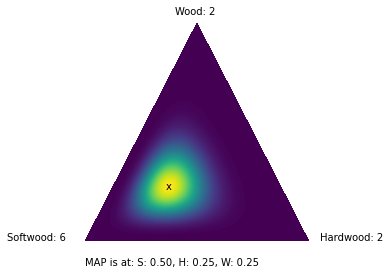

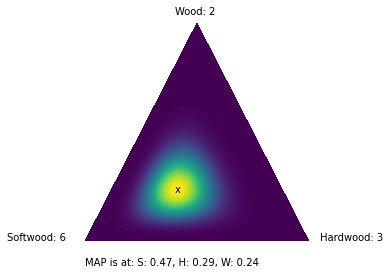

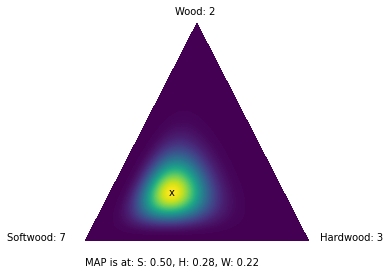

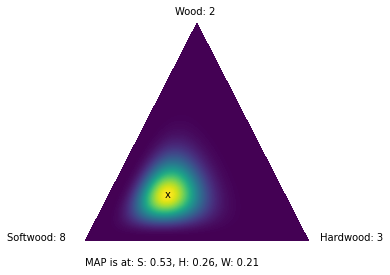

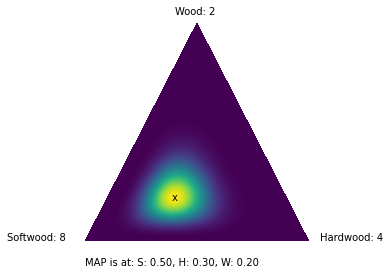

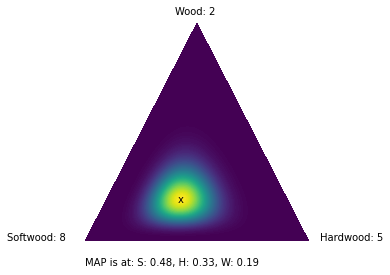

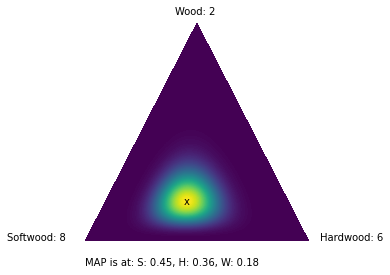

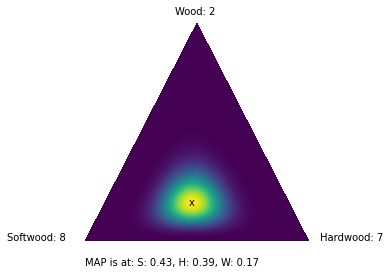

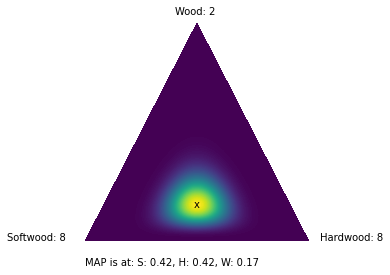

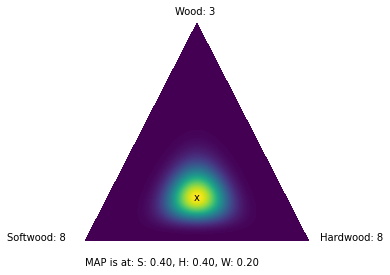

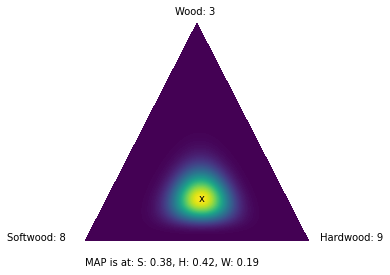

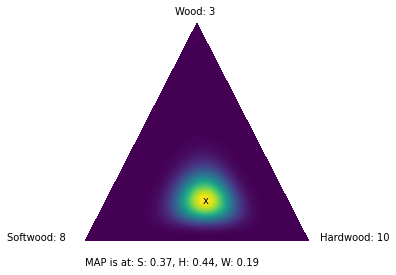

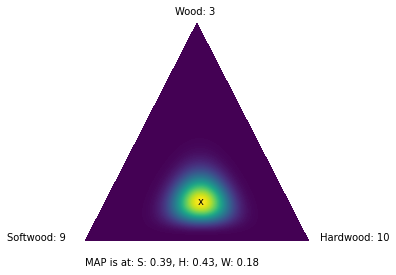

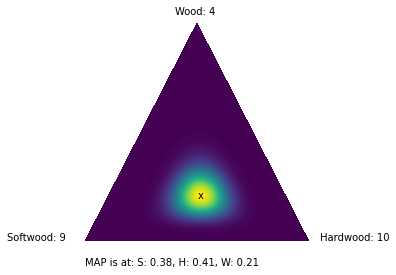

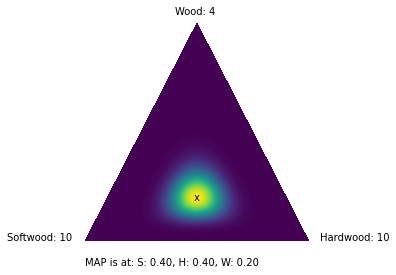

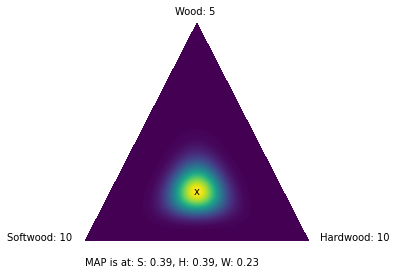

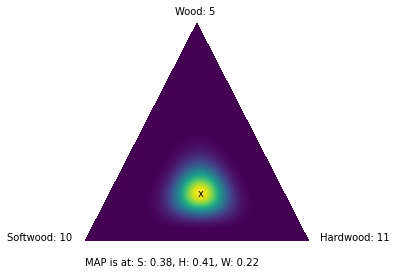

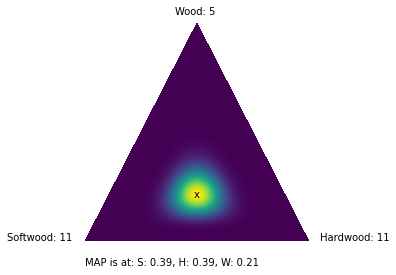

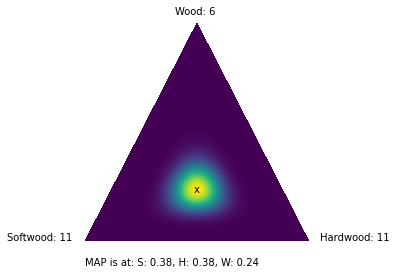

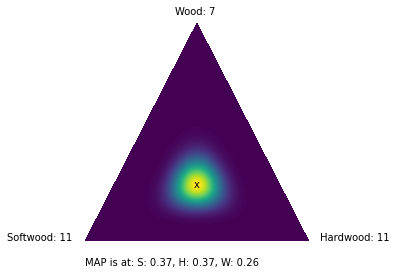

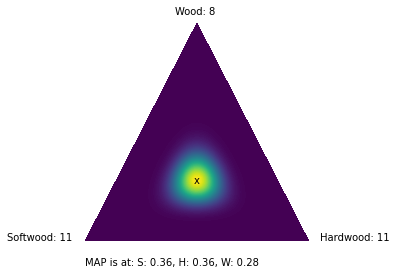

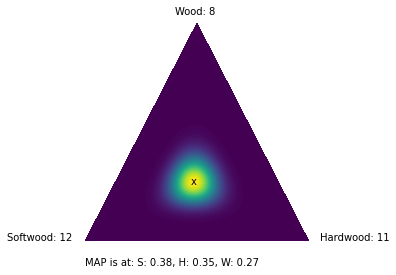

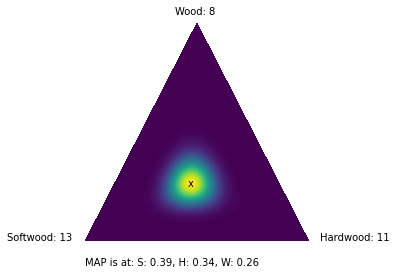

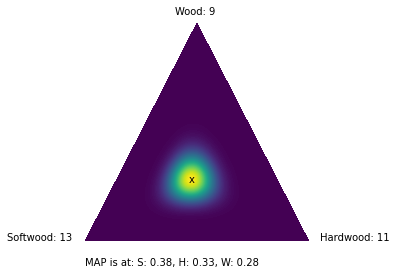

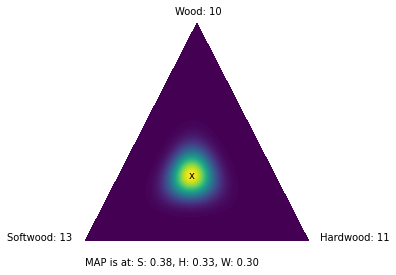

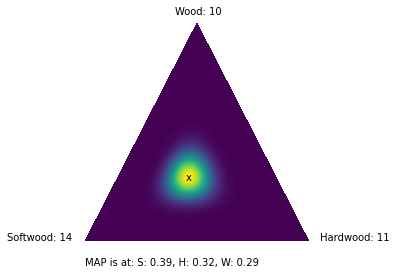

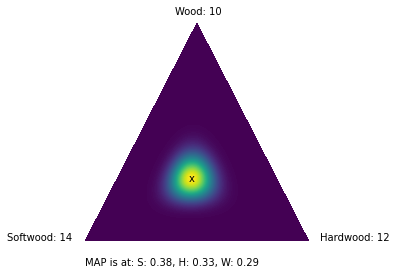

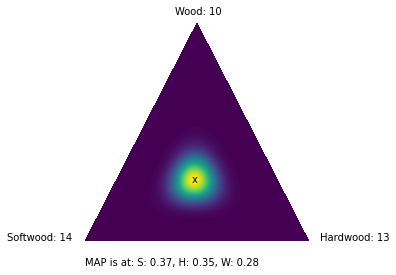

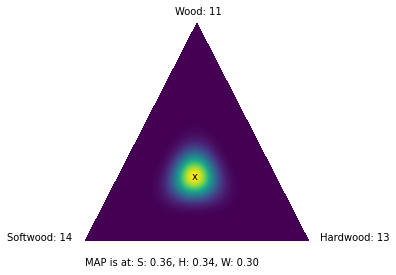

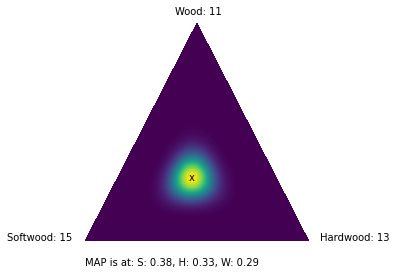

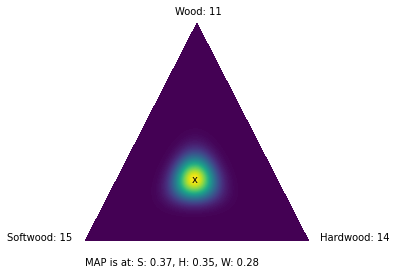

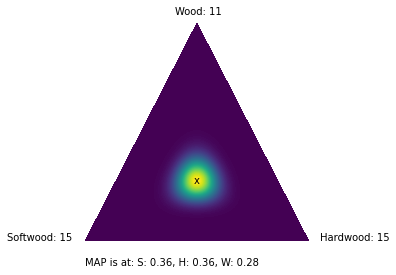

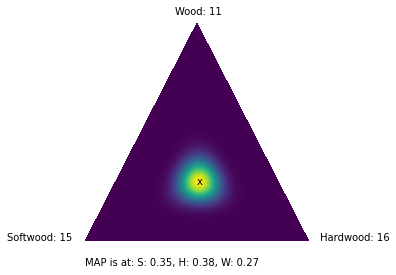

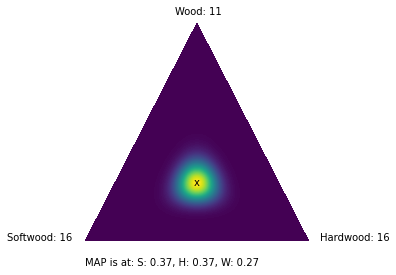

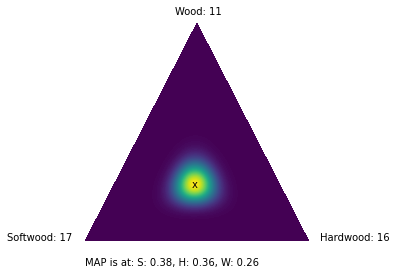

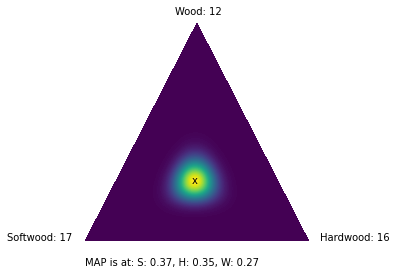

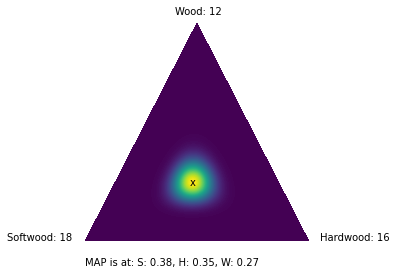

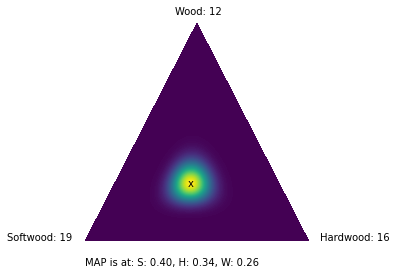

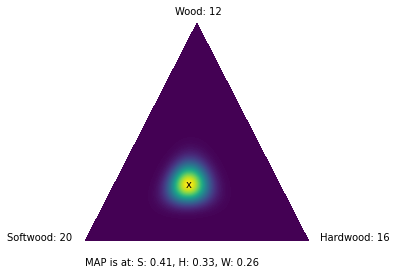

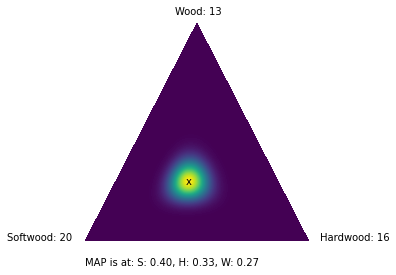

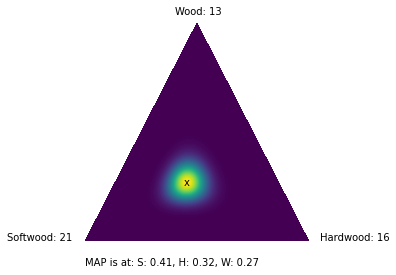

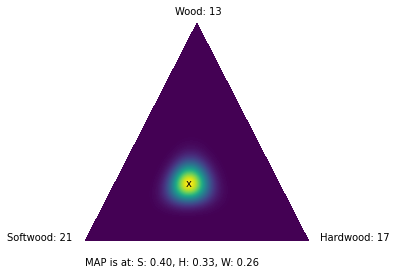

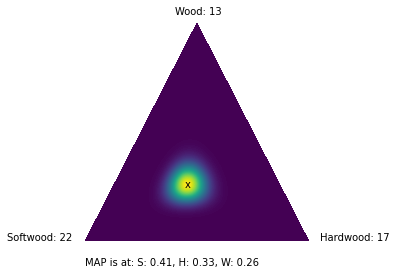

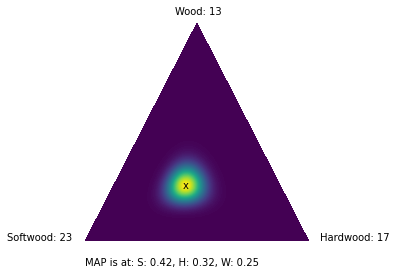

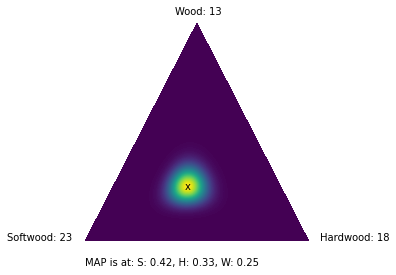

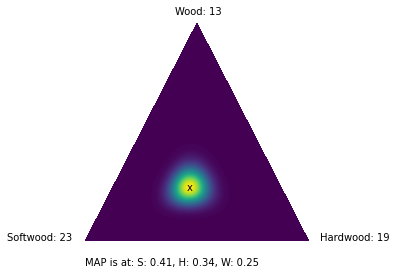

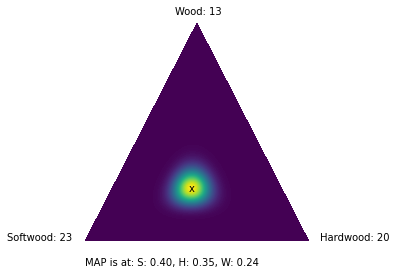

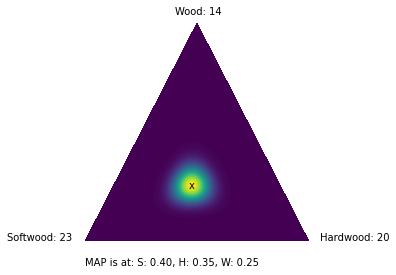

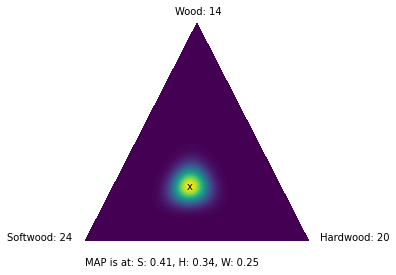

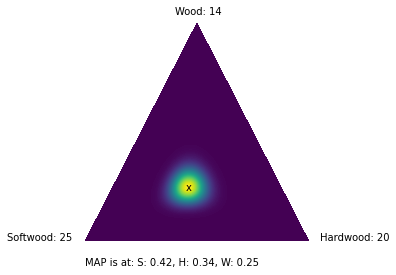

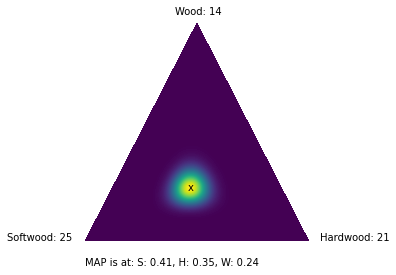

In [230]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75 ** 0.5]])
plot_dirichlet = PlotDirichlet(corners)
from collections import OrderedDict

for idx in range(len(wood) + 1):
    f, axes = plt.subplots(1, 1, figsize=(4, 4))
    counter = Counter(OrderedDict([('S', 0), ('H', 0), ('W', 0)]))
    counter.update(wood[:idx])
    alpha = [counter[x] for x in 'SHW']
    dist = DirichletDistribution(alpha, prior=[3, 3, 3])
    axes = plot_dirichlet.draw_pdf_contours(axes, dist, alpha, subdiv=7)
    axes.annotate(f'Softwood: {counter["S"]}', (0, 0), (-0.35, 0))
    axes.annotate(f'Hardwood: {counter["H"]}', (1, 0), (1.05, 0))
    axes.annotate(f'Wood: {counter["W"]}', (0.5, 0.75 ** 0.5), (0.4, 0.9))
    
    # MAP annotation
    mapcoords_bc = [(dist.prior[idx] + alpha - 1)
                                       / (dist.alphas.sum()
                                          + dist.prior.sum()
                                          - dist.alphas.shape[0])
                                      for idx, alpha in enumerate(dist.alphas)
                                      ]
    mapcoords = plot_dirichlet.bc2xy(mapcoords_bc)

    axes.annotate('x',
                  mapcoords,
                  horizontalalignment='center',
                  verticalalignment='center',
                  )
    axes.axis('off')
    plt.text(0, -0.1, f'MAP is at: S: {mapcoords_bc[0]:.02f}, H: {mapcoords_bc[1]:.02f}, W: {mapcoords_bc[2]:.02f}')
    plt.show()

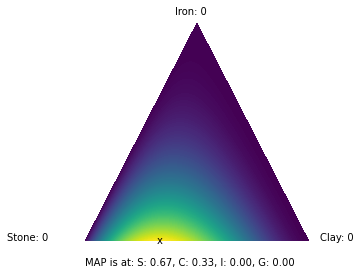

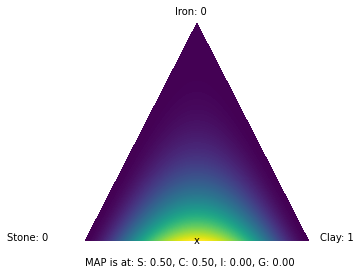

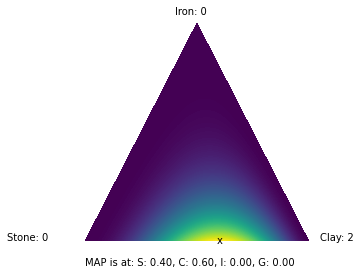

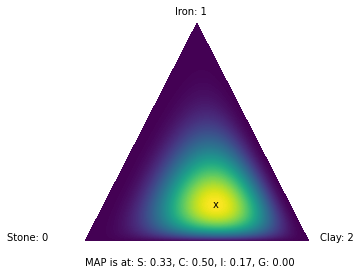

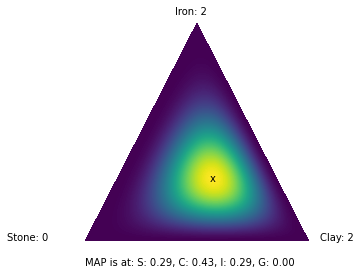

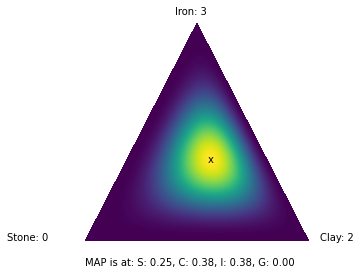

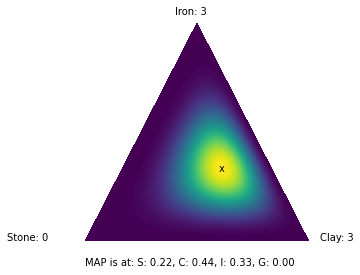

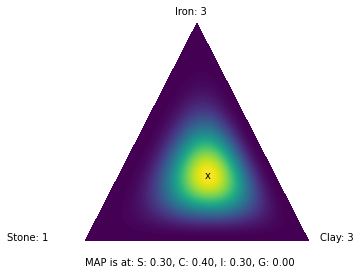

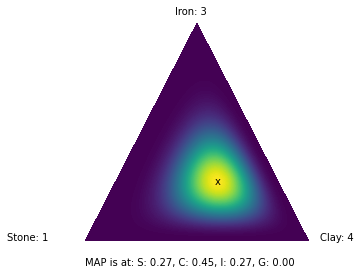

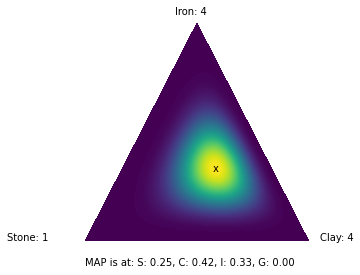

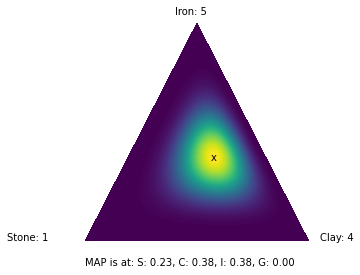

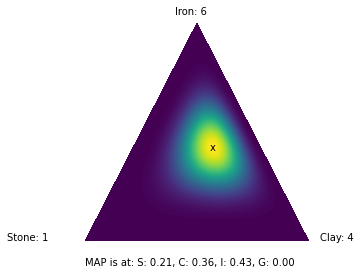

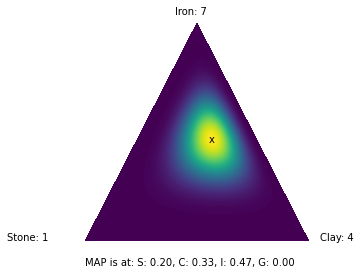

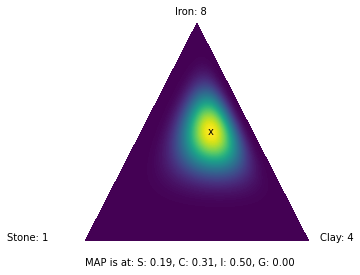

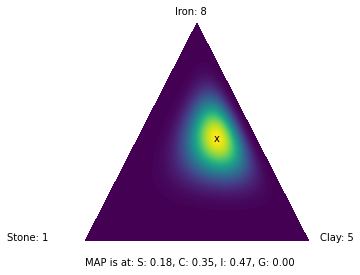

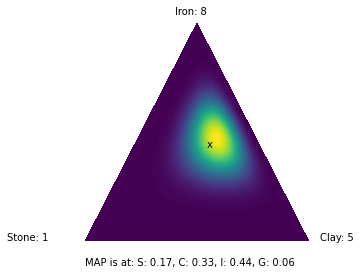

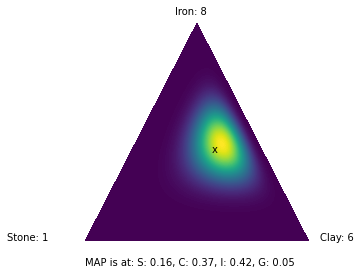

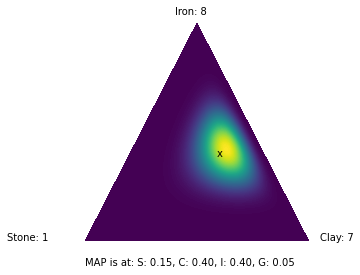

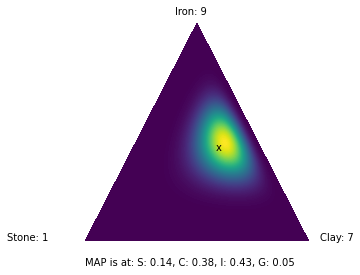

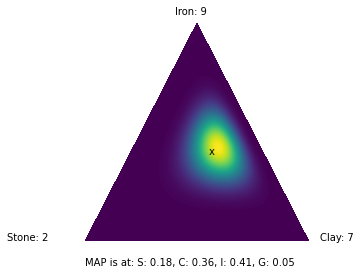

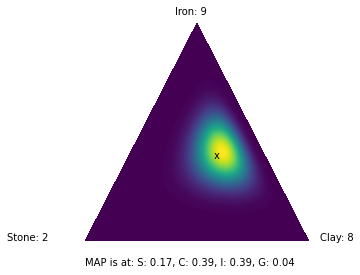

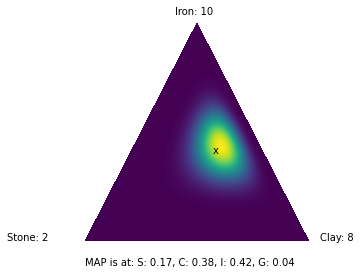

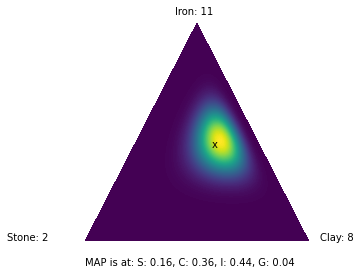

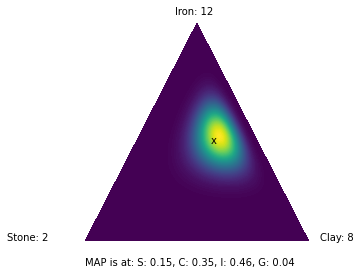

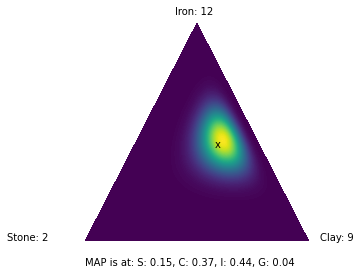

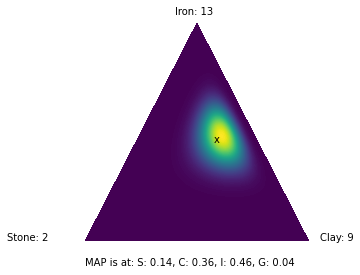

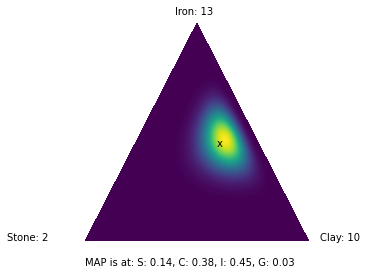

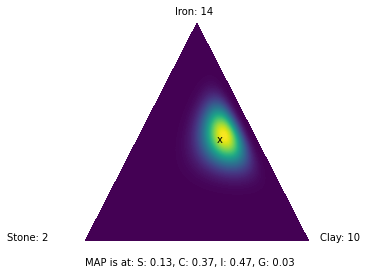

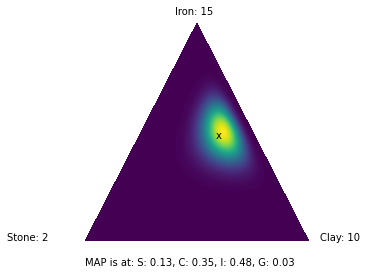

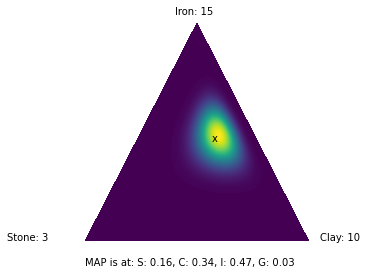

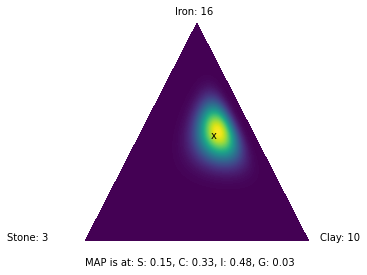

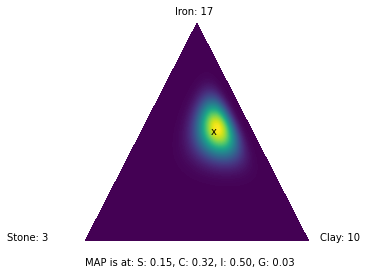

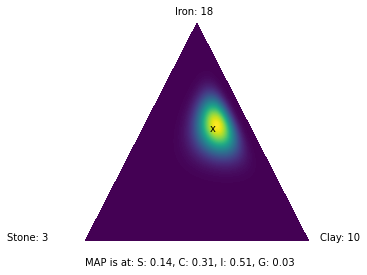

In [237]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75 ** 0.5]])
plot_dirichlet = PlotDirichlet(corners)
from collections import OrderedDict

for idx in range(len(nook_miles_island) + 1):
    f, axes = plt.subplots(1, 1, figsize=(4, 4))
    counter = Counter(OrderedDict([('S', 0), ('C', 0), ('I', 0)]))
    counter.update(nook_miles_island[:idx])
    alpha = [counter[x] for x in 'SCIG']
    dist = DirichletDistribution(alpha, prior=[3, 2, 1, 1])
    axes = plot_dirichlet.draw_pdf_contours(axes, dist, alpha, subdiv=7)
    axes.annotate(f'Stone: {counter["S"]}', (0, 0), (-0.35, 0))
    axes.annotate(f'Clay: {counter["C"]}', (1, 0), (1.05, 0))
    axes.annotate(f'Iron: {counter["I"]}', (0.5, 0.75 ** 0.5), (0.4, 0.9))
    
    # MAP annotation
    mapcoords_bc = [(dist.prior[idx] + alpha - 1)
                                       / (dist.alphas.sum()
                                          + dist.prior.sum()
                                          - dist.alphas.shape[0])
                                      for idx, alpha in enumerate(dist.alphas)
                                      ]
    mapcoords = plot_dirichlet.bc2xy(mapcoords_bc)

    axes.annotate('x',
                  mapcoords,
                  horizontalalignment='center',
                  verticalalignment='center',
                  )
    axes.axis('off')
    plt.text(0, -0.1, f'MAP is at: '
                      f'S: {mapcoords_bc[0]:.02f}, '
                      f'C: {mapcoords_bc[1]:.02f}, '
                      f'I: {mapcoords_bc[2]:.02f}, '
                      f'G: {mapcoords_bc[3]:.02f}')
    plt.show()

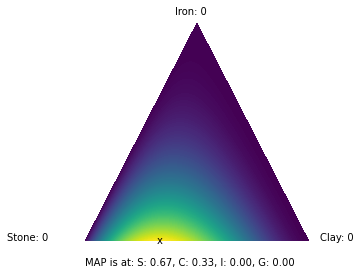

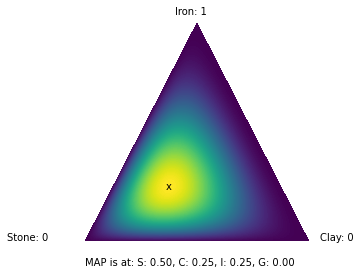

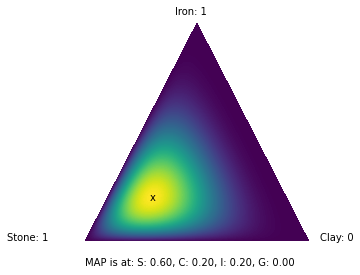

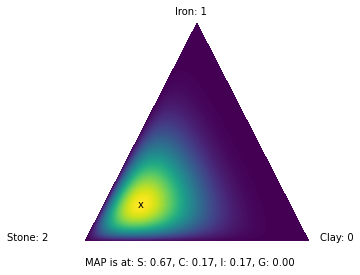

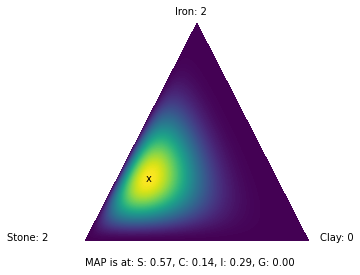

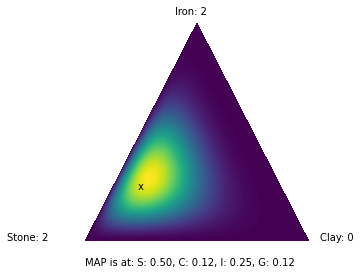

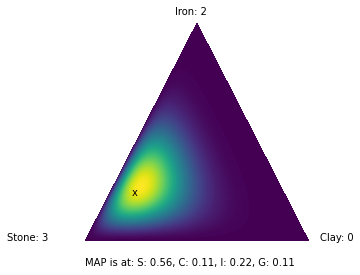

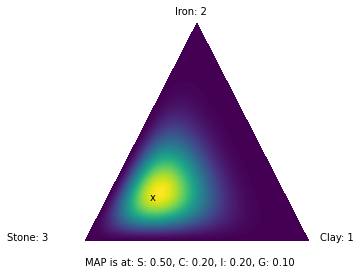

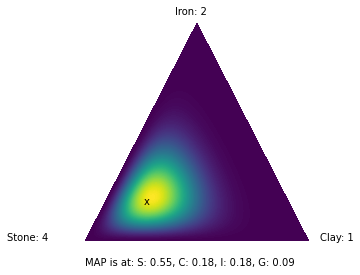

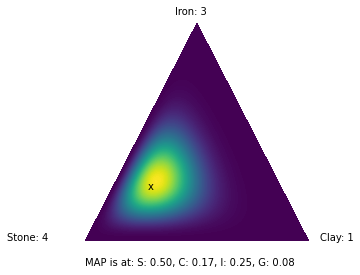

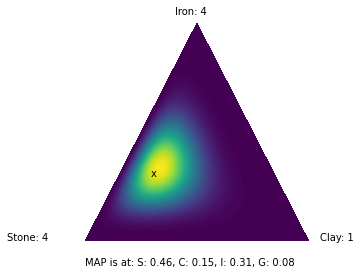

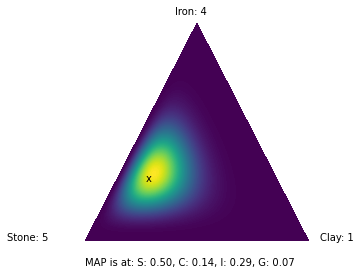

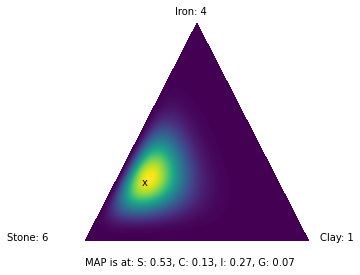

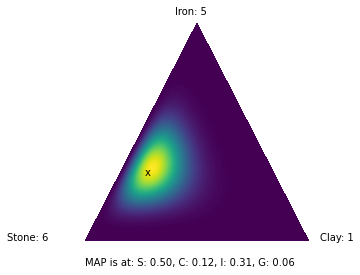

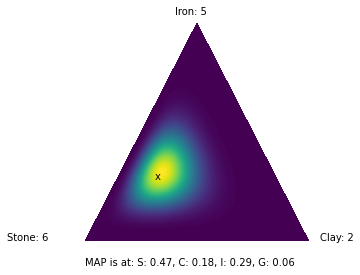

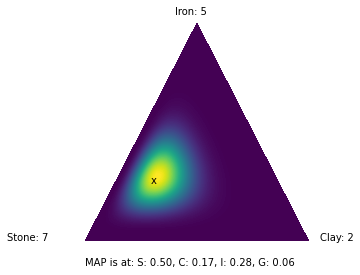

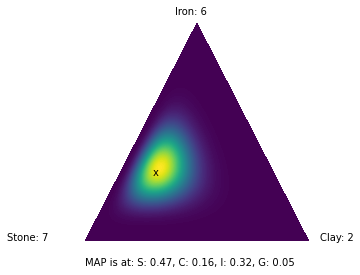

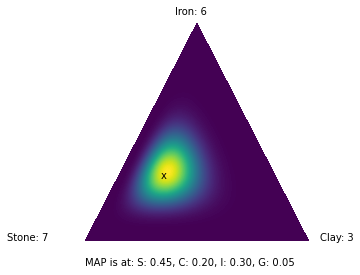

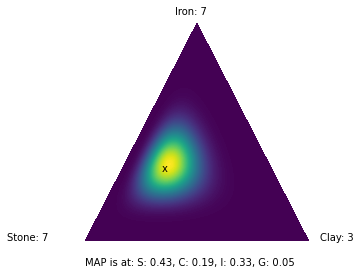

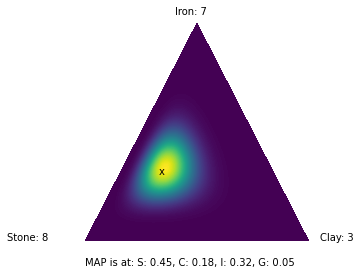

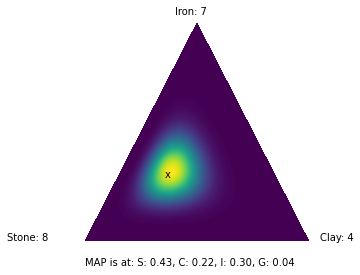

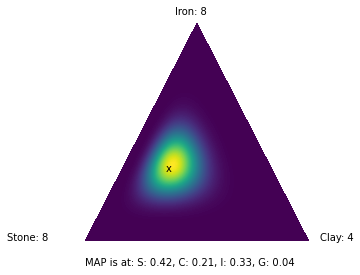

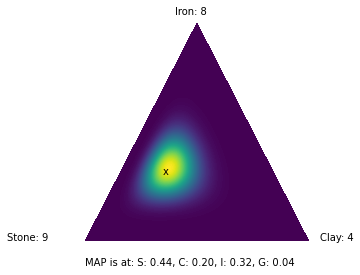

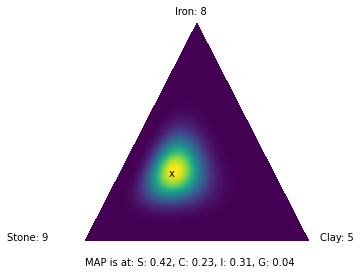

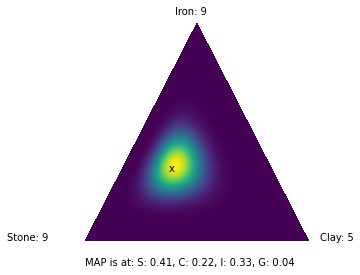

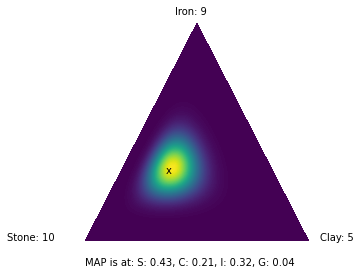

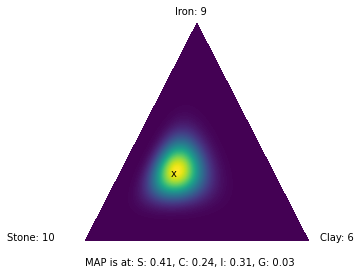

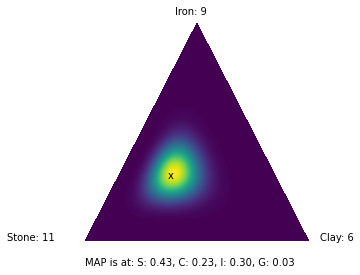

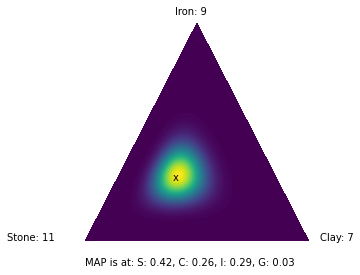

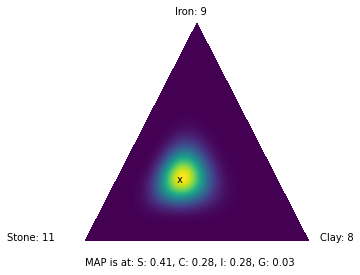

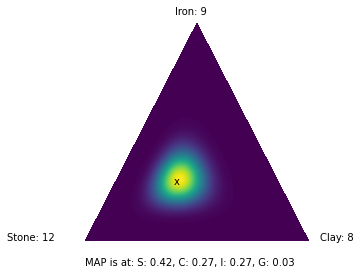

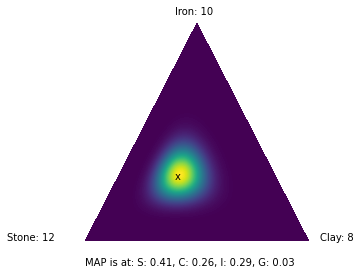

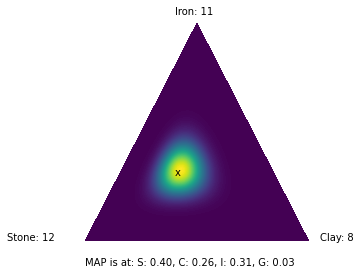

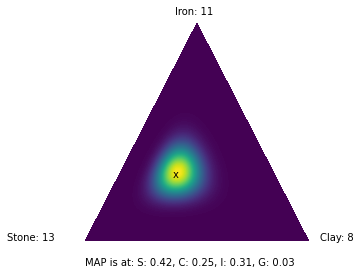

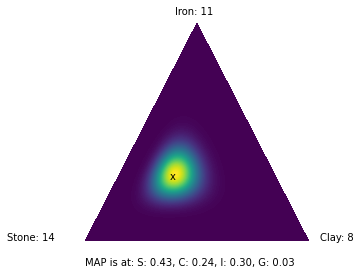

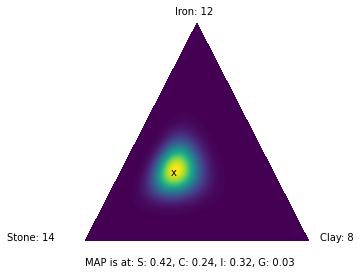

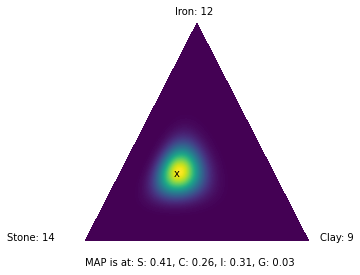

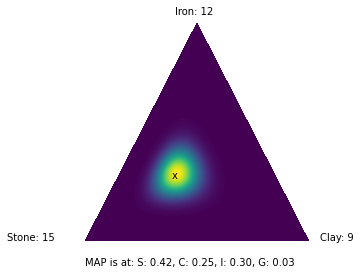

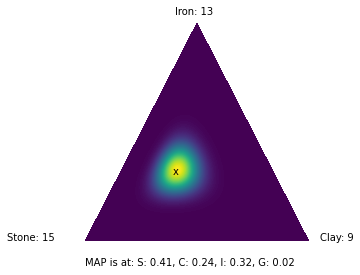

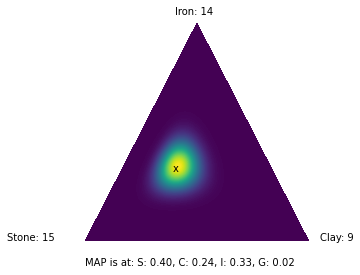

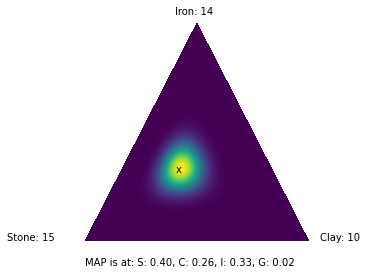

In [238]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75 ** 0.5]])
plot_dirichlet = PlotDirichlet(corners)
from collections import OrderedDict

for idx in range(len(island) + 1):
    f, axes = plt.subplots(1, 1, figsize=(4, 4))
    counter = Counter(OrderedDict([('S', 0), ('C', 0), ('I', 0)]))
    counter.update(island[:idx])
    alpha = [counter[x] for x in 'SCIG']
    dist = DirichletDistribution(alpha, prior=[3, 2, 1, 1])
    axes = plot_dirichlet.draw_pdf_contours(axes, dist, alpha, subdiv=7)
    axes.annotate(f'Stone: {counter["S"]}', (0, 0), (-0.35, 0))
    axes.annotate(f'Clay: {counter["C"]}', (1, 0), (1.05, 0))
    axes.annotate(f'Iron: {counter["I"]}', (0.5, 0.75 ** 0.5), (0.4, 0.9))
    
    # MAP annotation
    mapcoords_bc = [(dist.prior[idx] + alpha - 1)
                                       / (dist.alphas.sum()
                                          + dist.prior.sum()
                                          - dist.alphas.shape[0])
                                      for idx, alpha in enumerate(dist.alphas)
                                      ]
    mapcoords = plot_dirichlet.bc2xy(mapcoords_bc)

    axes.annotate('x',
                  mapcoords,
                  horizontalalignment='center',
                  verticalalignment='center',
                  )
    axes.axis('off')
    plt.text(0, -0.1, f'MAP is at: '
                      f'S: {mapcoords_bc[0]:.02f}, '
                      f'C: {mapcoords_bc[1]:.02f}, '
                      f'I: {mapcoords_bc[2]:.02f}, '
                      f'G: {mapcoords_bc[3]:.02f}')
    plt.show()

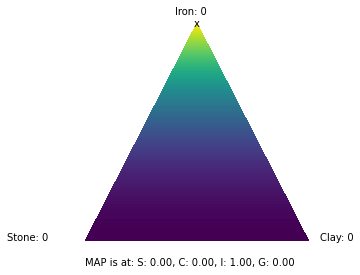

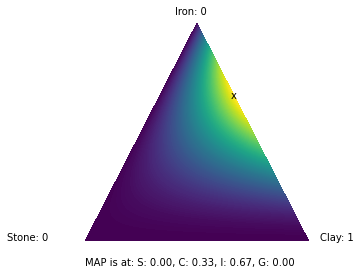

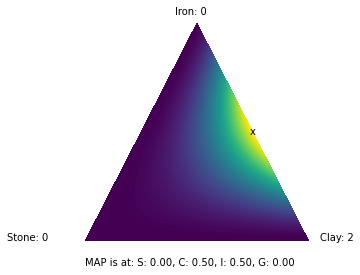

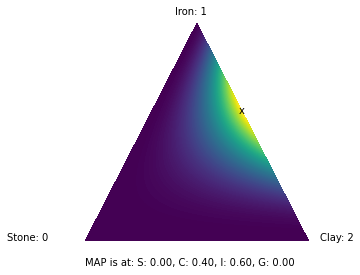

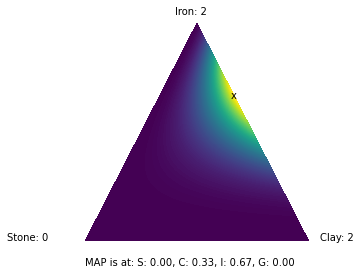

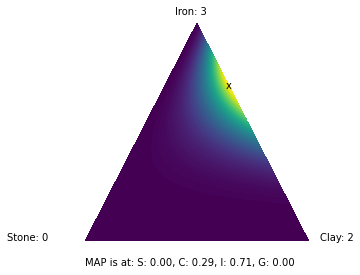

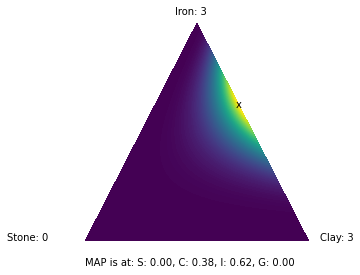

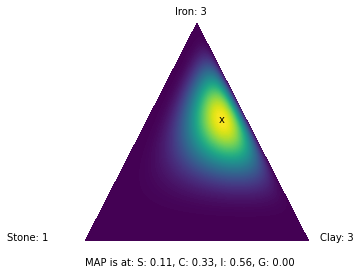

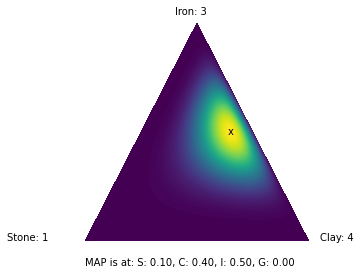

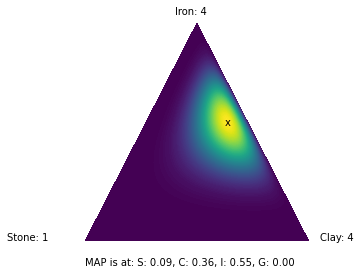

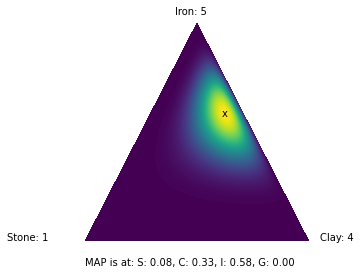

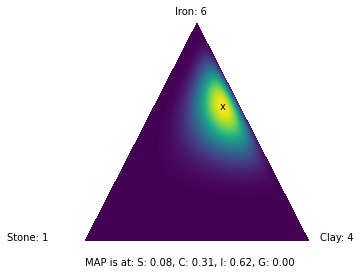

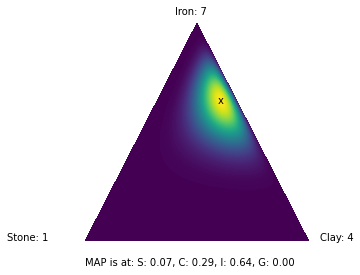

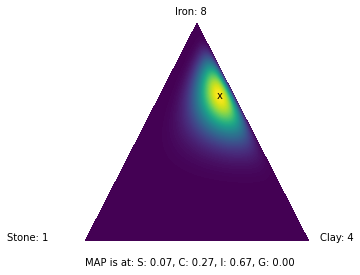

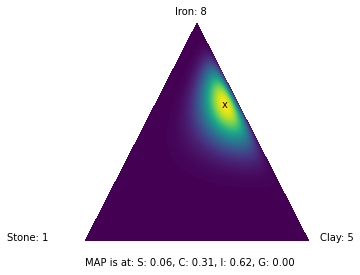

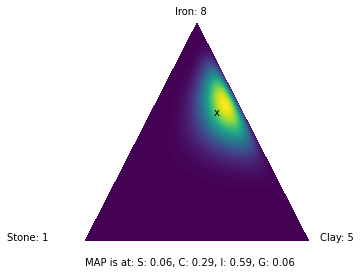

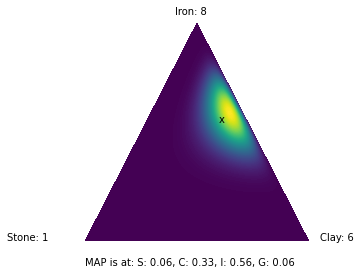

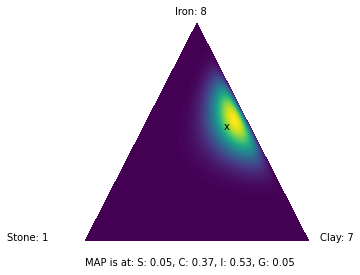

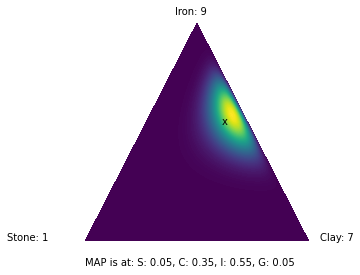

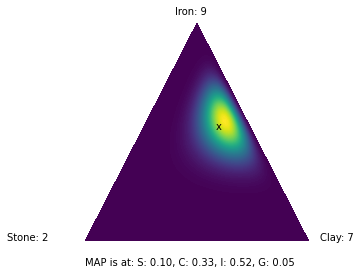

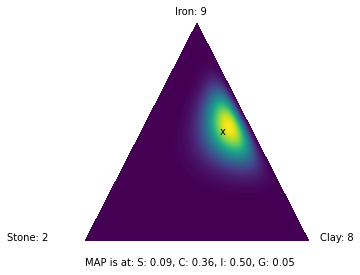

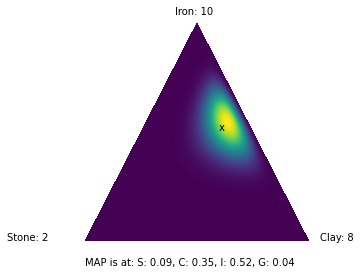

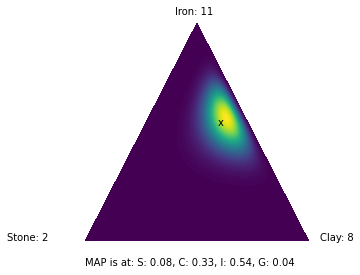

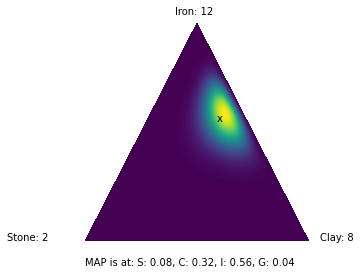

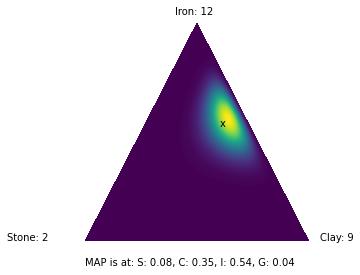

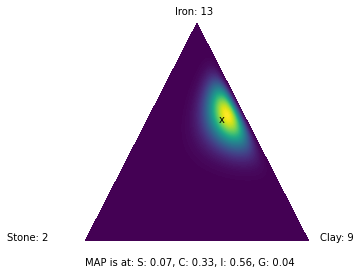

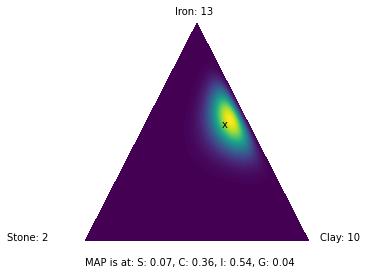

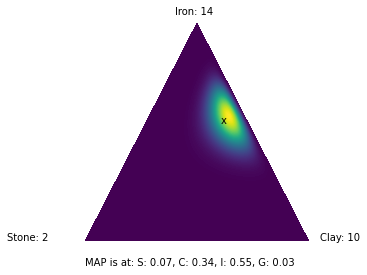

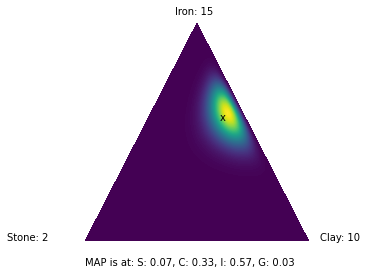

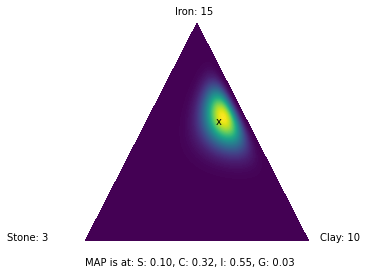

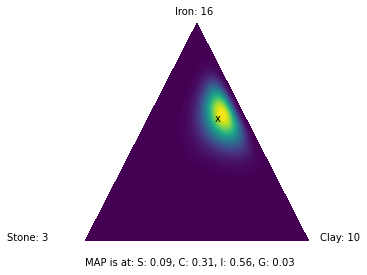

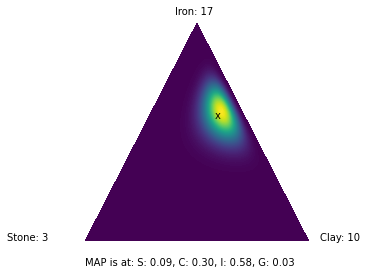

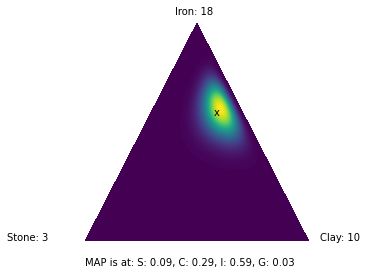

In [239]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75 ** 0.5]])
plot_dirichlet = PlotDirichlet(corners)
from collections import OrderedDict

for idx in range(len(nook_miles_island) + 1):
    f, axes = plt.subplots(1, 1, figsize=(4, 4))
    counter = Counter(OrderedDict([('S', 0), ('C', 0), ('I', 0)]))
    counter.update(nook_miles_island[:idx])
    alpha = [counter[x] for x in 'SCIG']
    dist = DirichletDistribution(alpha, prior=[1, 1, 3, 1])
    axes = plot_dirichlet.draw_pdf_contours(axes, dist, alpha, subdiv=7)
    axes.annotate(f'Stone: {counter["S"]}', (0, 0), (-0.35, 0))
    axes.annotate(f'Clay: {counter["C"]}', (1, 0), (1.05, 0))
    axes.annotate(f'Iron: {counter["I"]}', (0.5, 0.75 ** 0.5), (0.4, 0.9))
    
    # MAP annotation
    mapcoords_bc = [(dist.prior[idx] + alpha - 1)
                                       / (dist.alphas.sum()
                                          + dist.prior.sum()
                                          - dist.alphas.shape[0])
                                      for idx, alpha in enumerate(dist.alphas)
                                      ]
    mapcoords = plot_dirichlet.bc2xy(mapcoords_bc)

    axes.annotate('x',
                  mapcoords,
                  horizontalalignment='center',
                  verticalalignment='center',
                  )
    axes.axis('off')
    plt.text(0, -0.1, f'MAP is at: '
                      f'S: {mapcoords_bc[0]:.02f}, '
                      f'C: {mapcoords_bc[1]:.02f}, '
                      f'I: {mapcoords_bc[2]:.02f}, '
                      f'G: {mapcoords_bc[3]:.02f}')
    plt.show()